In [3]:
using QuantumOptics

In [4]:
function initializeHamiltonian(Vdd, gamma, delta, omega, decay)
    b = NLevelBasis(3)
    
    tgr = transition(b, 1, 2)
    trR = transition(b, 2, 3)
    eg = transition(b, 1, 1)
    er = transition(b, 2, 2)
    eR = transition(b, 3, 3)
    

    H = omega/2*(tgr + dagger(tgr)) + (Vdd*trR + conj(Vdd)*dagger(trR))/2 + gamma*eg + delta*eR
    
    J = [decay*(er - eR)]

    return b, H, J
end
b, Ham, Jp = initializeHamiltonian(1, 0, 0, 1, 0.5);



# Dynamics Calculation

0.33515219181750083 + 0.0im

/Users/jluke/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


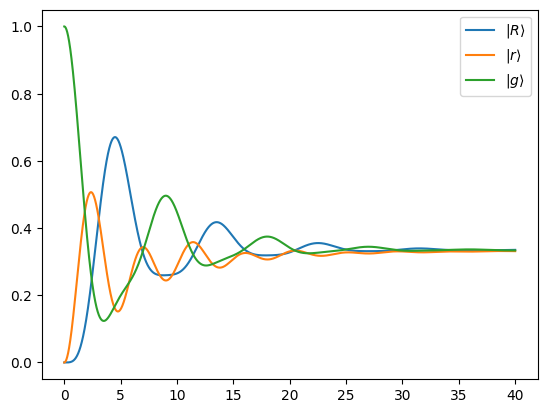

PyObject <matplotlib.legend.Legend object at 0x2c6255fd0>

In [5]:
psi0 = basisstate(b, 1)
T = [0:0.01:40;]
tout, psit = timeevolution.master(T, psi0, Ham, Jp; seed=2)
print(expect(dm(basisstate(b, 3)), psit)[end])
using PyPlot
plot(tout, expect(dm(basisstate(b, 3)), psit), label=L"$|R\rangle$")
plot(tout, expect(dm(basisstate(b, 2)), psit), label=L"$|r\rangle$")
plot(tout, expect(dm(basisstate(b, 1)), psit), label=L"$|g\rangle$")
legend()

In [6]:

function simulateDetuningScan(deltaArray;Vdd = 1,gamma = 0,   omega = 1, decay = 0.5 )
    eqR = zeros(size(deltaArray))

    for (ind, delta) in enumerate(deltaArray)
        b, Ham, Jp = initializeHamiltonian(Vdd, gamma, delta, omega, decay);
        psi0 = basisstate(b, 1)

        T = [0:0.01:40;]
        tout, psit = timeevolution.master(T, psi0, Ham, Jp; seed=2)
        eqR[ind] = abs(expect(dm(basisstate(b, 3)), psit)[end])
    end
    return eqR
end

simulateDetuningScan (generic function with 1 method)

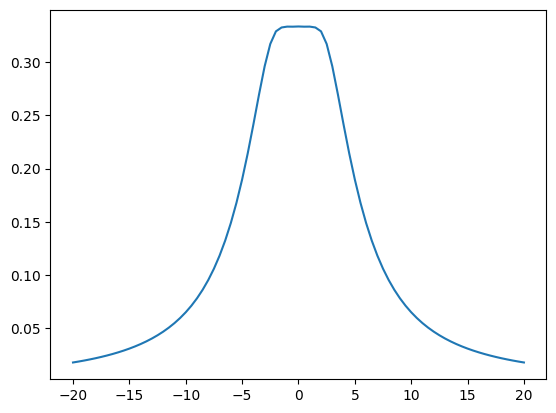

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2c73e5310>

In [7]:
deltaArray = [-20:0.5:20...]
rydPop = simulateDetuningScan(deltaArray, Vdd = 1,  decay= 0.6)
plot(deltaArray, rydPop)


# Add Distance Randomization

In [68]:
using Random
using Statistics
using NearestNeighbors
using Distributions

#Conversion Factors and Constants
amuToKg=  1.66054e-27 
e = 1.602176634e-19;
a0 = 5.29177210903e-11;
Debye = 0.39*e*a0;
epsilon0 = 8.8541878128e-12;
hbar = 1.05457182e-34;
kB = 1.38064852e-23;



Rb = Dict("mass" => 85.467*amuToKg, 'w'=> 2*pi* [84, 183, 183 ], "Dipole"=>  8000*a0*e)
KRb = Dict("mass"=>  (39.0983 + 85.467)*amuToKg, "w"=> 2*pi* [110,240,240 ], "Dipole"=> 0.56*Debye )
function generateAtoms(mu, AtomNum, TrapFreq, KbT)
    coordList = []
    for TrapFreqI in TrapFreq
        sigma = sqrt(KbT / TrapFreqI)
        coord = rand(Normal(mu, sigma), AtomNum)
        push!(coordList, coord)
    end
    return hcat(coordList...)
end


function exciteRydberg(AtomCoord, numOfRyd)
    AtomInd = collect(1:size(AtomCoord, 1))
    
    indofRyd = sample(AtomInd, numOfRyd, replace=false)
    print(indofRyd)
    RydCoord = [AtomCoord[indofRyd, i] for i in 1:size(AtomCoord, 2)]
    NonRyd = [deleteat!(copy(AtomCoord[:, i]), indofRyd) for i in 1:size(AtomCoord, 2)]
    
    return RydCoord, NonRyd
end


function findNearestNeighbor(RydCoord, KRbCoord)
    KRbCoord = KRbCoord'
    RydCoord = RydCoord'
    tree = KDTree(KRbCoord)
    closestNeighborList = []

    for atom in eachrow(RydCoord)
        print(atom)
        dist2Krb, indOfKRb = knn(tree, atom, 1)
        push!(closestNeighborList, (dist2Krb[1], indOfKRb[1]))
    end

    return closestNeighborList
end






findNearestNeighbor (generic function with 1 method)

In [ ]:
NumOfRb = 8000
NumOfKRb = 8000
Temp =  0.5e-6 
RbAtomCoord = generateAtoms(0, NumOfRb, Rb["mass"]*Rb['w'].^2, kB*Temp) #Rb coord
KRbAtomCoord = generateAtoms(0, NumOfKRb, KRb["mass"]*KRb["w"].^2, kB*Temp) #Krb Coord
RydCoord, NonRyd = exciteRydberg(RbAtomCoord,1) #Returns the coordinates of the Rydberg atoms
findNearestNeighbor(RbAtomCoord, KRbAtomCoord)

In [53]:
size(KRbAtomCoord, 2)

3